# Casual trip rates

In [26]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed


%matplotlib inline

pd.set_option("display.max_columns", 6)
plt.rcParams.update({'font.size': 20})
style.use("fivethirtyeight")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/thesis/output/casual_final.csv', index_col=0)
df = df.reset_index(drop=True)

In [4]:
#add a year to previous years data

def add_year(x):
  year = int(x[3]) + 1
  y = x[:3] + str(year) + x[3+1:]
  return y

for i in range(df.shape[0]):
  if 'Previous' in df.loc[i, 'city']:
    df.loc[i, 'month'] = add_year(df.loc[i, 'month'])

In [5]:
df['after_treatment'] = np.where(df['month']>'2019-05', True, False)

## creating the 4 groups

In [6]:
# Chicago
group1 = ['Chicago', 'Columbus', 'Pittsburgh', 'Portland', 'Philadelphia', \
          'Chicago Previous', 'Boston Previous', 'Washington DC Previous', 'New York City Previous']
df1 = df[df['city'].isin(group1)]
df1['treat'] = np.where(df1['city']=='Chicago', True, False)

In [7]:
# Boston
group2 = ['Boston', 'Columbus', 'Pittsburgh', 'Portland', 'Philadelphia', \
          'Chicago Previous', 'Boston Previous', 'Washington DC Previous', 'New York City Previous']
df2 = df[df['city'].isin(group2)]
df2['treat'] = np.where(df2['city']=='Boston', True, False)

In [8]:
# New York City
group3 = ['New York City', 'Columbus', 'Pittsburgh', 'Portland', 'Philadelphia', \
          'Chicago Previous', 'Boston Previous', 'Washington DC Previous', 'New York City Previous']
df3 = df[df['city'].isin(group3)]
df3['treat'] = np.where(df3['city']=='New York City', True, False)

In [9]:
# DC
group4 = ['Washington DC', 'Columbus', 'Pittsburgh', 'Portland', 'Philadelphia', \
          'Chicago Previous', 'Boston Previous', 'Washington DC Previous', 'New York City Previous']
df4 = df[df['city'].isin(group4)]
df4['treat'] = np.where(df4['city']=='Washington DC', True, False)

## first plot

In [13]:
def first_plot_weights(df, city_name):
  features = ["casual_rates"]
  inverted = (df.query("~after_treatment") # filter pre-intervention period
            .pivot(index='city', columns="month")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state
  y = inverted[city_name].values # Chicago
  X = inverted.drop(columns=city_name).values  # other states

  weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
  print(weights_lr)

In [36]:
def first_plot(df, city_name):
  features = ["casual_rates"]
  inverted = (df.query("~after_treatment") # filter pre-intervention period
            .pivot(index='city', columns="month")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state
  y = inverted[city_name].values # Chicago
  X = inverted.drop(columns=city_name).values  # other states

  weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_

  calif_synth_lr = (df.query("~treat")
                  .pivot(index='month', columns="city")["casual_rates"]
                  .values.dot(weights_lr))
  plt.figure(figsize=(24,6))
  plt.plot(df.query("treat")["month"], df.query("treat")["casual_rates"], label=city_name)
  plt.plot(df.query("treat")["month"], calif_synth_lr, label="Synthetic Control")
  plt.ylabel("Casual Trip Rate")
  plt.xlabel("Month")
  plt.legend();


## second plot

In [16]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

In [17]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [15]:
def second_plot_weights(df, city_name):
  features = ["casual_rates"]
  inverted = (df.query("~after_treatment") # filter pre-intervention period
            .pivot(index='city', columns="month")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state
  y = inverted[city_name].values # Chicago
  X = inverted.drop(columns=city_name).values  # other states

  weights = get_w(X, y)
  print(weights)

In [39]:
def second_plot(df, city_name):
  features = ["casual_rates"]
  inverted = (df.query("~after_treatment") # filter pre-intervention period
            .pivot(index='city', columns="month")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state
  y = inverted[city_name].values # Chicago
  X = inverted.drop(columns=city_name).values  # other states

  calif_weights = get_w(X, y)
  calif_synth = df.query("~treat").pivot(index='month', columns="city")["casual_rates"].values.dot(calif_weights)

  plt.figure(figsize=(24,6))
  plt.plot(df.query("treat")["month"], df.query("treat")["casual_rates"], label=city_name)
  plt.plot(df.query("treat")["month"], calif_synth, label="Synthetic Control")
  #plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
  plt.ylabel("Casual Trip Rate")
  plt.xlabel("Month")
  plt.legend();

## third plot

In [ ]:
def synthetic_control(city, pool, data):
    
    features = ["casual_rates"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='city', columns="month")[features]
                .T)
    
    y = inverted[city].values # treated
    X = inverted.drop(columns=city).values # donor pool

    weights = get_w(X, y)
    synthetic = (data[data['city']!=city]
                 .pivot(index='month', columns="city")["casual_rates"]
                 .values.dot(weights))

    return (data[data['city']==city][["city", "month", "casual_rates", "after_treatment"]]
            .assign(synthetic=synthetic))

In [ ]:
def third_plot(df, city_name):
  features = ["casual_rates"]
  inverted = (df.query("~after_treatment") # filter pre-intervention period
            .pivot(index='city', columns="month")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state
  y = inverted[city_name].values # Chicago
  X = inverted.drop(columns=city_name).values  # other states

  calif_weights = get_w(X, y)
  calif_synth = df.query("~treat").pivot(index='month', columns="city")["casual_rates"].values.dot(calif_weights)

  control_pool = df["city"].unique()
  parallel_fn = delayed(partial(synthetic_control, pool=control_pool, data=df))
  synthetic_city = Parallel(n_jobs=8)(parallel_fn(city) for city in control_pool)
  plt.figure(figsize=(22,6))
  for city in synthetic_city:
    plt.plot(city["month"], city["casual_rates"] - city["synthetic"], color="C5",alpha=0.4)

  plt.plot(df.query("treat")["month"], df.query("treat")["casual_rates"] - calif_synth,
        label=city_name);

#plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
#plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
  plt.ylabel("Casual Trip Rates")
  plt.title("Cities - Synthetic Across Time")
  plt.legend();


In [11]:
dfs = [df1, df2, df3, df4]
city_names = ['Chicago', "Boston", "New York City", "Washington DC"]

In [14]:
for i in range(4):
  first_plot_weights(dfs[i], city_names[i])

[-0.51335798  0.88099634 -0.03584034  1.10356568  1.54526623  0.0259911
 -0.00273432 -1.0160718 ]
[-0.84935581  0.46144853 -0.24027943  2.22320108  1.44236966  0.17503538
  0.01788783 -0.84171807]
[-1.19605812e-01  5.04679444e-02 -8.00768982e-04  1.05871986e+00
  4.22008867e-01  6.03974494e-02  2.09813079e-02 -3.76369608e-01]
[ 0.18771773  0.33065018  0.17096068 -1.32028516 -1.06222308  0.12321632
  0.02333159  0.96453399]


In [18]:
for i in range(4):
  second_plot_weights(dfs[i], city_names[i])

[0.00000000e+00 5.57707219e-01 0.00000000e+00 0.00000000e+00
 4.40234626e-01 0.00000000e+00 2.05815452e-03 1.40341019e-17]
[0.00000000e+00 2.19214856e-01 0.00000000e+00 1.47221873e-01
 5.62532085e-01 2.01498701e-19 7.10311858e-02 4.59369059e-17]
[6.63541526e-16 2.42016579e-16 0.00000000e+00 7.64823955e-01
 2.35176045e-01 0.00000000e+00 0.00000000e+00 2.26824243e-16]
[3.27757526e-01 1.13534425e-01 0.00000000e+00 2.18669138e-01
 1.33085817e-17 2.57794946e-02 2.27783634e-02 2.91481053e-01]


In [34]:
plt.rcParams.update({'font.size': 16})

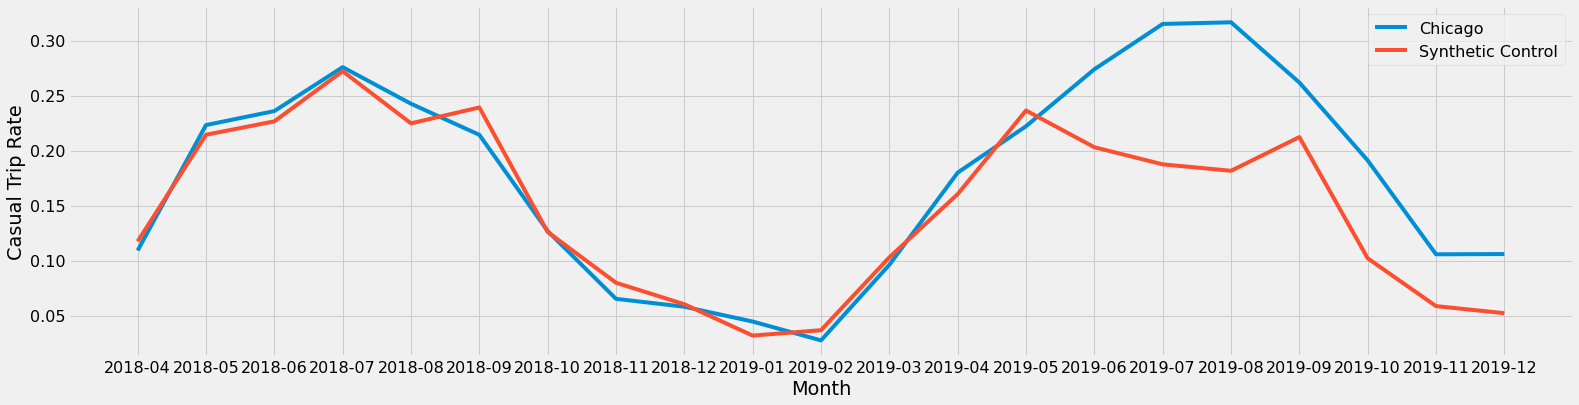

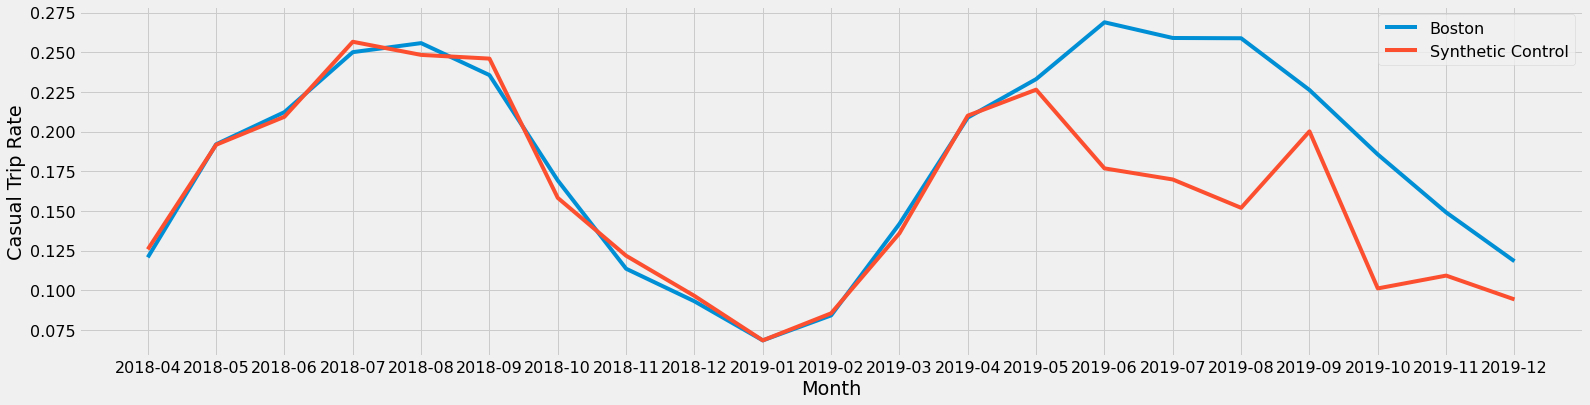

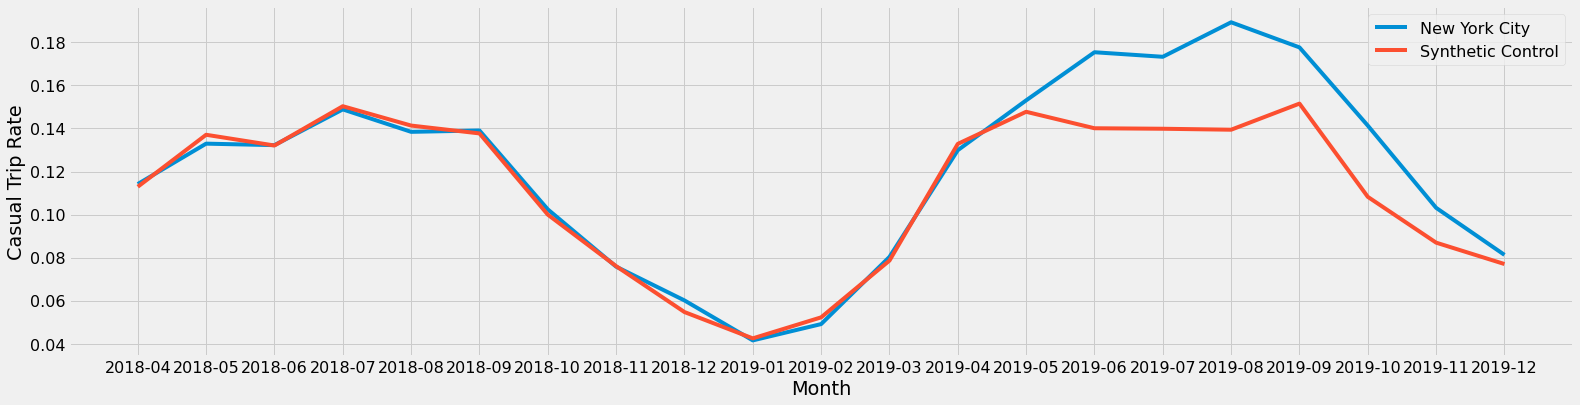

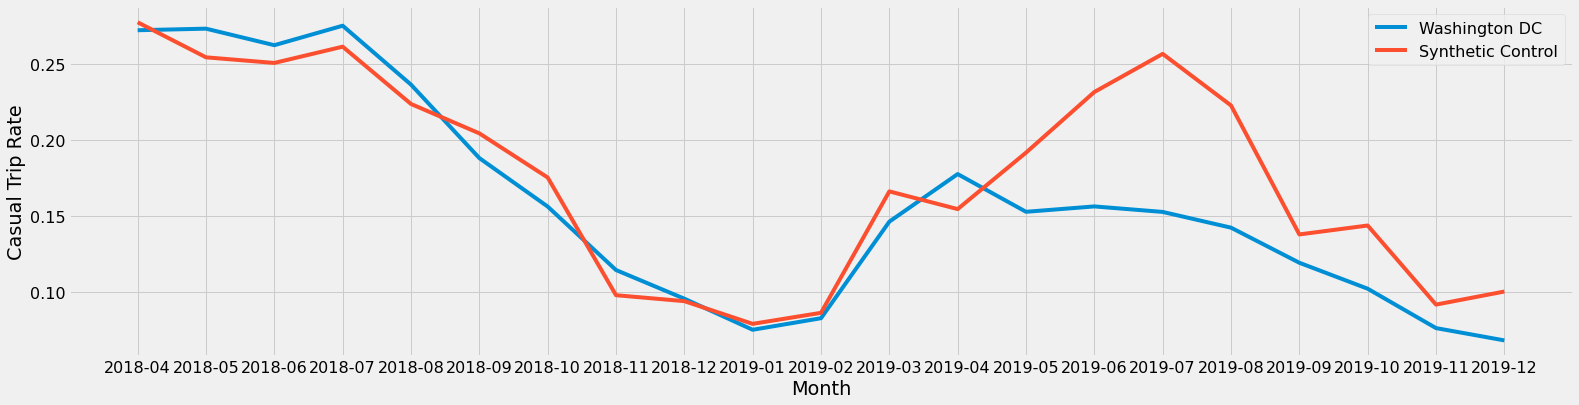

In [37]:
for i in range(4):
  first_plot(dfs[i], city_names[i])

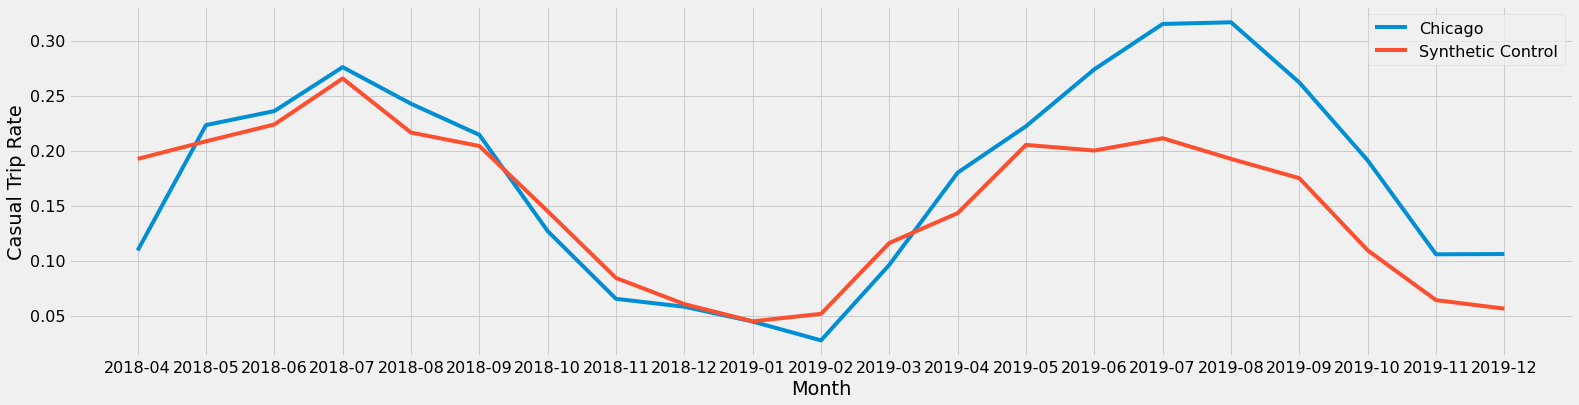

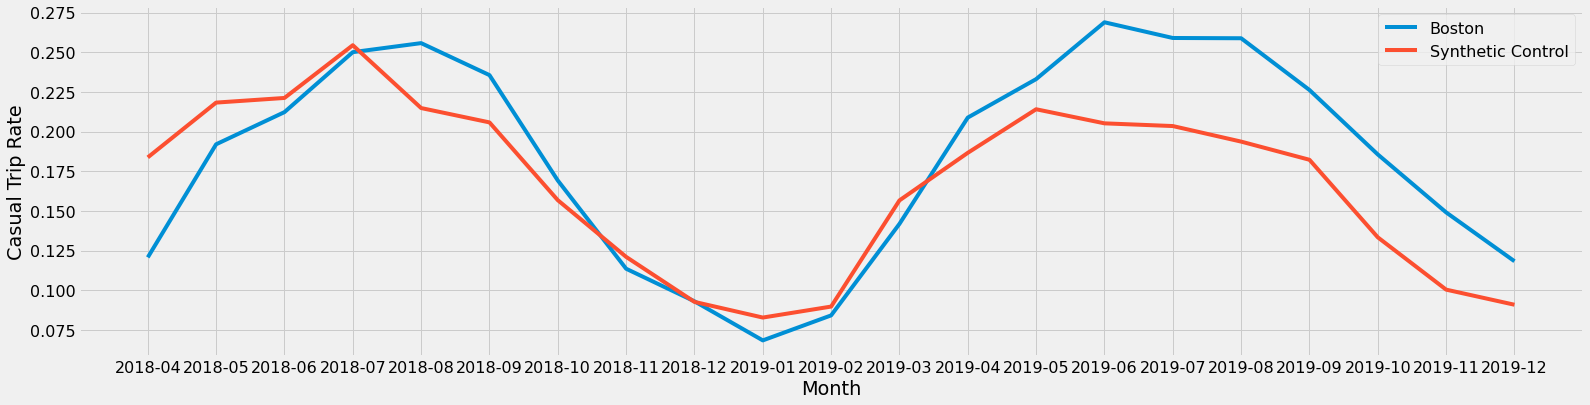

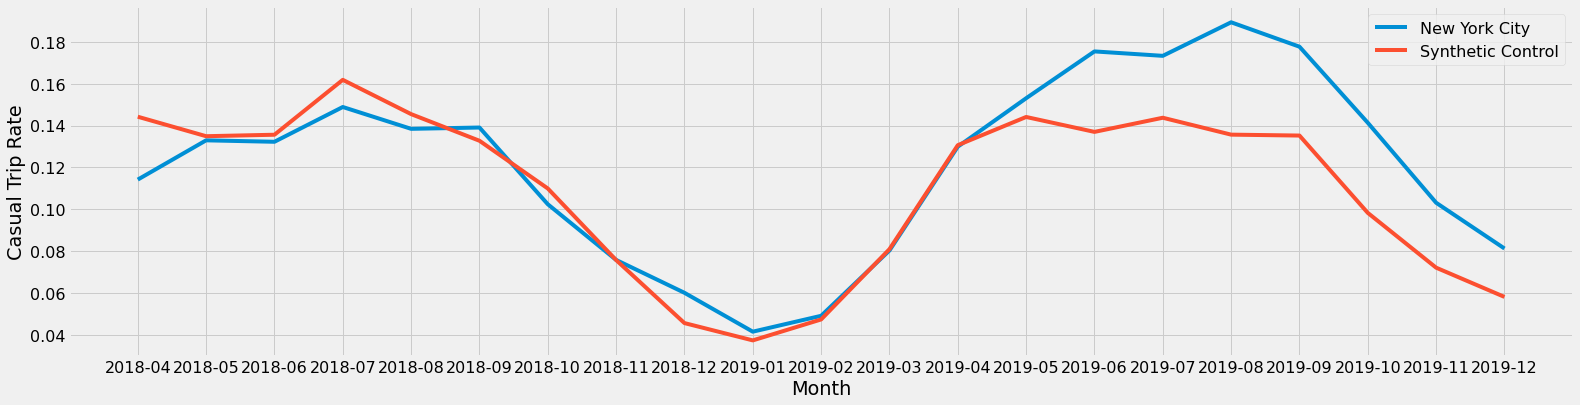

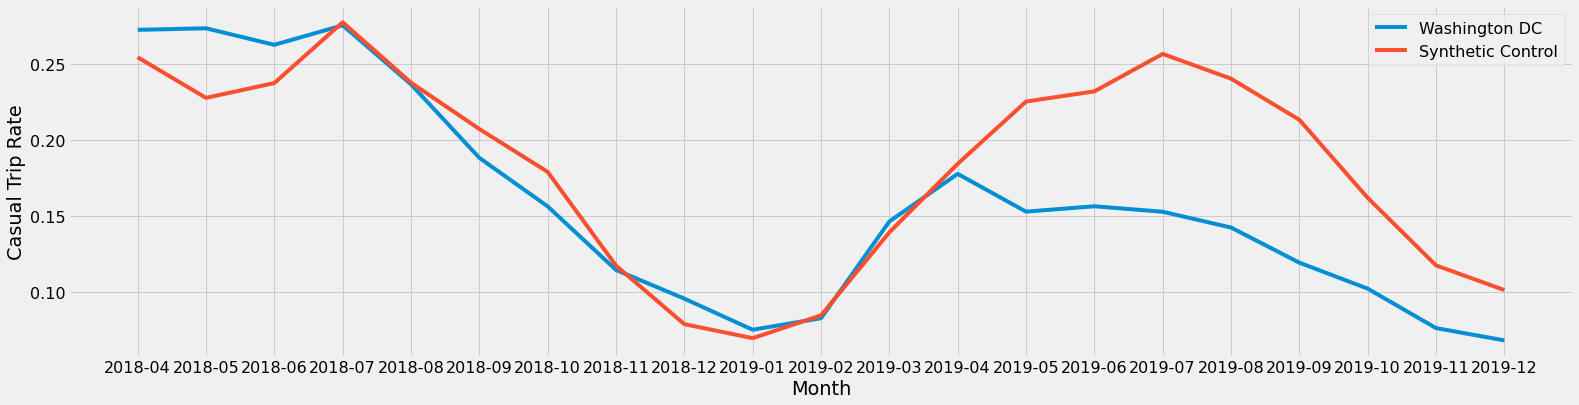

In [40]:
for i in range(4):
  second_plot(dfs[i], city_names[i])

In [ ]:
for i in range(4):
  third_plot(dfs[i], city_names[i])